In [190]:
import mediapipe as mp
import cv2
import time
import os
import glob
from pathlib import Path
import pandas as pd 
from mat4py import loadmat
import numpy as np
from math import cos, sin
import matplotlib.pyplot as plt

In [228]:
def extract_points(file_path):
    points = []   
    indexs = []   
    mylist = [Path(f) for f in glob.glob(file_path+"/*.jpg")]  
    #print(mylist)
    mp_face_mesh = mp.solutions.face_mesh    
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode = True)   
    for pic in mylist:
        img = cv2.imread(str(pic))
        results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        if not results.multi_face_landmarks:
            indexs.append(mylist.index(pic))
            continue
        landmarks = results.multi_face_landmarks[0]
        
        for landmark in landmarks.landmark:
            x = landmark.x
            y = landmark.y
            points.append(x)
            points.append(y)
            
    # we have 2000 and 468 point for every pic        
    points = np.array(points).reshape((-1,468*2))
    points = pd.DataFrame(points)
    return points,indexs

In [346]:
df,indexs = extract_points('AFLW2000')

In [347]:
df

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.485651,0.686891,0.489194,0.639722,0.489803,0.647257,0.479730,0.562529,0.490558,0.621214,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665669,0.471336,0.676091,0.464005
1,0.441502,0.642091,0.417273,0.592251,0.448839,0.610546,0.435994,0.545069,0.415757,0.576966,...,0.522467,0.506956,0.511393,0.511724,0.500658,0.514913,0.584451,0.500244,0.594060,0.495387
2,0.317797,0.799190,0.321328,0.776498,0.318316,0.782066,0.311064,0.745973,0.321459,0.767816,...,0.334413,0.717794,0.330334,0.720868,0.328639,0.723342,0.373404,0.713071,0.377643,0.709798
3,0.503922,0.694309,0.469521,0.653913,0.489504,0.658751,0.444433,0.590285,0.461756,0.637613,...,0.507567,0.500958,0.497731,0.510606,0.490586,0.518652,0.595615,0.455611,0.602670,0.444623
4,0.510238,0.669038,0.492729,0.604797,0.499756,0.624468,0.467368,0.542362,0.488200,0.584701,...,0.520501,0.481912,0.510743,0.488652,0.505667,0.492681,0.602484,0.452699,0.611310,0.448576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.515443,0.683951,0.532837,0.625785,0.518815,0.639885,0.511650,0.560010,0.535343,0.607497,...,0.549179,0.497122,0.541875,0.503230,0.540073,0.508401,0.629060,0.479723,0.635765,0.474628
1849,0.543907,0.689845,0.565286,0.635285,0.549288,0.646834,0.545584,0.562769,0.568493,0.616073,...,0.582101,0.493105,0.575992,0.500255,0.574974,0.506461,0.659800,0.479817,0.667754,0.470887
1850,0.586373,0.680103,0.604407,0.627700,0.593793,0.645848,0.602947,0.568153,0.609593,0.610428,...,0.663857,0.537300,0.654205,0.539478,0.648903,0.541426,0.734017,0.547668,0.743284,0.540139
1851,0.491617,0.692910,0.500626,0.637631,0.497282,0.649833,0.490064,0.559349,0.503418,0.617386,...,0.570748,0.490321,0.557697,0.496594,0.550279,0.502602,0.673963,0.481876,0.684592,0.474287


In [194]:
import scipy.io as sio

In [195]:
def get_list_from_filenames(file_path):
    lines=[Path(f).stem for f in glob.glob(file_path)]
    return lines

def get_ypr_from_mat(mat_path):
    # Get yaw, pitch, roll from .mat annotation.
    # They are in radians
    mat = sio.loadmat(mat_path)
    # [pitch yaw roll tdx tdy tdz scale_factor]
    pre_pose_params = mat['Pose_Para'][0]
    # Get [pitch, yaw, roll]
    pose_params = pre_pose_params[:3]
    return pose_params

class AFLW2000():
    def __init__(self, data_dir,file_path, img_ext='.jpg', annot_ext='.mat', image_mode='RGB'):
        self.data_dir = data_dir
        self.file_path = file_path
        self.img_ext = img_ext
        self.annot_ext = annot_ext

        filename_list = get_list_from_filenames(data_dir)
        filename_list.sort()
        self.X_train = filename_list
        self.y_train = filename_list ####????????????
        self.image_mode = image_mode
        self.length = len(filename_list)

    def get_labels(self, index):

        mat_path = os.path.join(self.file_path,self.y_train[index] + self.annot_ext)


        # We get the pose in radians
        pose = get_ypr_from_mat(mat_path)
        # And convert to degrees.
        pitch = pose[0] * 180 / np.pi
        yaw = pose[1] * 180 / np.pi
        roll = pose[2] * 180 / np.pi
        # Bin values
        bins = np.array(range(-99, 102, 3))
        labels =np.digitize([yaw, pitch, roll], bins) - 1
        cont_labels = [yaw, pitch, roll]
          
   
        return  cont_labels

In [196]:
demo = AFLW2000("AFLW2000/*.mat",'AFLW2000/')
labels = []

for i in range(2000):
    x = np.array(demo.get_labels(i), dtype=np.float32)
    labels.append(x)
    
labels = np.array(labels, dtype=np.float32)
labels_df=pd.DataFrame(labels,columns=['yaw','pitch','roll'])

In [197]:
labels_df

,yaw,pitch,roll
0,1.044306,-22.874239,4.908885
1,68.155243,26.932743,17.243670
2,50.485413,-10.579652,-13.570645
3,17.143373,-10.048455,-21.392782
4,68.640549,-50.544582,-59.207973
...,...,...,...
1995,-4.035367,-11.293093,6.022806
1996,-81.288437,-13.327947,10.081747
1997,82.005562,-82.961685,-86.483292
1998,-68.249336,-24.090857,25.869925


In [198]:
labels_df.drop(indexs,inplace=True)

In [199]:
labels_df.shape

(1853, 3)

In [238]:
def normalize(points):
    
    xpoint_cen = points.iloc[:,2]
    ypoint_cen = points.iloc[:,3]
    xpoint_eyebrow = points.iloc[:,592]
    ypoint_eyebrow = points.iloc[:,593]
    df_col = list(points.columns)
    
    for col in df_col:
        #print(col)
        if col % 2 == 0 :
            #print(col)
            points[col] = (xpoint_cen - points[col]) #/ xpoint_eyebrow
        else:
            #print(col)
            points[col] = (ypoint_cen - points[col]) #/ ypoint_eyebrow
    return points        

In [239]:
normalize(df)

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.003543,-0.047169,0.0,0.0,-0.489803,-0.647257,-0.479730,-0.562529,-0.490558,-0.621214,...,-0.559712,-0.485137,-0.548437,-0.492813,-0.541429,-0.500371,-0.665669,-0.471336,-0.676091,-0.464005
1,-0.024229,-0.049840,0.0,0.0,-0.448839,-0.610546,-0.435994,-0.545069,-0.415757,-0.576966,...,-0.522467,-0.506956,-0.511393,-0.511724,-0.500658,-0.514913,-0.584451,-0.500244,-0.594060,-0.495387
2,0.003530,-0.022692,0.0,0.0,-0.318316,-0.782066,-0.311064,-0.745973,-0.321459,-0.767816,...,-0.334413,-0.717794,-0.330334,-0.720868,-0.328639,-0.723342,-0.373404,-0.713071,-0.377643,-0.709798
3,-0.034401,-0.040395,0.0,0.0,-0.489504,-0.658751,-0.444433,-0.590285,-0.461756,-0.637613,...,-0.507567,-0.500958,-0.497731,-0.510606,-0.490586,-0.518652,-0.595615,-0.455611,-0.602670,-0.444623
4,-0.017510,-0.064241,0.0,0.0,-0.499756,-0.624468,-0.467368,-0.542362,-0.488200,-0.584701,...,-0.520501,-0.481912,-0.510743,-0.488652,-0.505667,-0.492681,-0.602484,-0.452699,-0.611310,-0.448576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.017394,-0.058166,0.0,0.0,-0.518815,-0.639885,-0.511650,-0.560010,-0.535343,-0.607497,...,-0.549179,-0.497122,-0.541875,-0.503230,-0.540073,-0.508401,-0.629060,-0.479723,-0.635765,-0.474628
1849,0.021379,-0.054560,0.0,0.0,-0.549288,-0.646834,-0.545584,-0.562769,-0.568493,-0.616073,...,-0.582101,-0.493105,-0.575992,-0.500255,-0.574974,-0.506461,-0.659800,-0.479817,-0.667754,-0.470887
1850,0.018034,-0.052402,0.0,0.0,-0.593793,-0.645848,-0.602947,-0.568153,-0.609593,-0.610428,...,-0.663857,-0.537300,-0.654205,-0.539478,-0.648903,-0.541426,-0.734017,-0.547668,-0.743284,-0.540139
1851,0.009009,-0.055280,0.0,0.0,-0.497282,-0.649833,-0.490064,-0.559349,-0.503418,-0.617386,...,-0.570748,-0.490321,-0.557697,-0.496594,-0.550279,-0.502602,-0.673963,-0.481876,-0.684592,-0.474287


In [202]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [203]:
parameters={
            'bootstrap':[True],
            'max_leaf_nodes':[100,101,102,103,104,105] }

In [204]:
#rf = GridSearchCV(RandomForestRegressor(),parameters)

In [205]:
rf = RandomForestRegressor(max_leaf_nodes = 95,bootstrap=True)

In [206]:
rf.fit(df,labels_df['yaw'])

RandomForestRegressor(max_leaf_nodes=95)

In [207]:
#rf.best_params_

In [348]:
rf.predict(df)

array([ 3.54566977, 67.0635691 , 20.8047259 , ...,  1.70178905,
       -1.14631473, -5.69541832])

In [349]:
rf.score(df,labels_df['yaw'])

0.9632985364051857

In [350]:
rf1 = RandomForestRegressor(max_leaf_nodes = 110,bootstrap=True)

In [351]:
rf1.fit(df,labels_df['pitch'])

RandomForestRegressor(max_leaf_nodes=110)

In [352]:
rf2 = RandomForestRegressor(max_leaf_nodes = 110,bootstrap=True)

In [353]:
rf2.fit(df,labels_df['roll'])

RandomForestRegressor(max_leaf_nodes=110)

In [354]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [358]:
df1,index = extract_points('ml1')

In [359]:
df1

,0,1,2,3,4,5,6,7,8,9,...,926,927,928,929,930,931,932,933,934,935
0,0.485651,0.686891,0.489194,0.639722,0.489803,0.647257,0.47973,0.562529,0.490558,0.621214,...,0.559712,0.485137,0.548437,0.492813,0.541429,0.500371,0.665669,0.471336,0.676091,0.464005


In [360]:
image = cv2.imread("ml1/image00002.jpg", cv2.IMREAD_COLOR)

In [361]:
labels_df

,yaw,pitch,roll
0,1.044306,-22.874239,4.908885
1,68.155243,26.932743,17.243670
2,50.485413,-10.579652,-13.570645
3,17.143373,-10.048455,-21.392782
5,0.685565,-1.536199,-12.643008
...,...,...,...
1991,-16.261791,-17.552992,2.208994
1992,-24.621336,-21.058870,7.035404
1994,32.493248,-8.940119,-6.218641
1995,-4.035367,-11.293093,6.022806


In [362]:
labels_df

,yaw,pitch,roll
0,1.044306,-22.874239,4.908885
1,68.155243,26.932743,17.243670
2,50.485413,-10.579652,-13.570645
3,17.143373,-10.048455,-21.392782
5,0.685565,-1.536199,-12.643008
...,...,...,...
1991,-16.261791,-17.552992,2.208994
1992,-24.621336,-21.058870,7.035404
1994,32.493248,-8.940119,-6.218641
1995,-4.035367,-11.293093,6.022806


In [368]:
yaw = rf.predict(df1)
pitch = rf1.predict(df1)
roll = rf2.predict(df1)

In [369]:
print(yaw,pitch,roll)

[3.54566977] [-20.05460028] [3.53225631]


In [381]:
image = cv2.imread("ml1/image00002.jpg", cv2.IMREAD_COLOR)

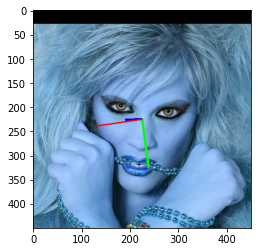

In [382]:
plt.imshow(draw_axis(image,yaw,pitch,roll))